In [150]:

key_id = 'PK04UHV69AF2QULV4REU'
secret_key = '7g1qUN7qjsfW3U6oSccYYtHyQdoewJ12ANDQmSKd'
endpoint = 'https://paper-api.alpaca.markets'

In [2]:
!pip3 install alpaca-py
!pip3 install gym_anytrading
!pip3 install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 6.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.2/97.2 kB 3.1 MB/s eta 0:00:00
  Using cached typing_extensions-4.3.0-py3-none-any.whl (25 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.0.1
    Uninstalling typing_extensions-4.0.1:
      Successfully uninstalled typing_extensions-4.0.1
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
 

In [151]:
import gym
import gym_anytrading

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

In [152]:
# connect to alpaca api
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime


stock_client = StockHistoricalDataClient(key_id, secret_key)

# get 1 years worth data on Nvidia by the day. Could also use TimeFrame.Minute for daily data
request_params = StockBarsRequest(symbol_or_symbols=['NVDA'],
                                  timeframe=TimeFrame.Day,
                                  start=datetime(2020, 1, 1),
                                  end=datetime(2022, 1, 1)
                                  )

bars = stock_client.get_stock_bars(request_params)
# should probably define all of the stocks we will be using in an array and then
# aggregate them all into a single dataframe so they are all in one place for our algorithm
# but should try our algorithm with just 1 stock until we know it works

In [153]:
bars.df

open     high       low   close  \
symbol timestamp                                                      
NVDA   2020-01-02 05:00:00+00:00  238.85  239.910  236.7200  239.91   
       2020-01-03 05:00:00+00:00  235.00  237.830  234.1000  236.07   
       2020-01-06 05:00:00+00:00  232.36  237.270  231.2700  237.06   
       2020-01-07 05:00:00+00:00  238.20  241.770  236.3900  239.93   
       2020-01-08 05:00:00+00:00  239.76  242.040  238.1490  240.38   
...                                  ...      ...       ...     ...   
       2021-12-27 05:00:00+00:00  296.40  310.865  296.4000  309.45   
       2021-12-28 05:00:00+00:00  313.11  313.300  300.1181  303.22   
       2021-12-29 05:00:00+00:00  303.11  305.480  293.6600  300.01   
       2021-12-30 05:00:00+00:00  298.24  304.570  295.4000  295.86   
       2021-12-31 05:00:00+00:00  296.52  300.300  293.3057  294.11   

                                      volume  trade_count        vwap  
symbol timestamp                                                       
NVDA   2020-01-02 05:00:00+00:00   5941969.0      67912.0  238.723319  
       2020-01-03 05:00:00+00:00   5145208.0      63605.0  236.384392  
       2020-01-06 05:00:00+00:00   6572812.0      73912.0  235.468778  
       2020-01-07 05:00:00+00:00   7980144.0      81624.0  239.855220  
       2020-01-08 05:00:00+00:00   6931017.0      70240.0  240.313148  
...                                      ...          ...         ...  
       2021-12-27 05:00:00+00:00  40331037.0     594185.0  307.225490  
       2021-12-28 05:00:00+00:00  42214335.0     629167.0  304.595486  
       2021-12-29 05:00:00+00:00  34308945.0     495749.0  298.631331  
       2021-12-30 05:00:00+00:00  30885650.0     408098.0  300.514442  
       2021-12-31 05:00:00+00:00  26649553.0     361122.0  295.736504  

[505 rows x 7 columns]

In [154]:
data=bars.df.reset_index()
data.head()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,NVDA,2020-01-02 05:00:00+00:00,238.85,239.91,236.720,239.91,5941969.0,67912.0,238.723319
1,NVDA,2020-01-03 05:00:00+00:00,235.00,237.83,234.100,236.07,5145208.0,63605.0,236.384392
2,NVDA,2020-01-06 05:00:00+00:00,232.36,237.27,231.270,237.06,6572812.0,73912.0,235.468778
3,NVDA,2020-01-07 05:00:00+00:00,238.20,241.77,236.390,239.93,7980144.0,81624.0,239.855220
4,NVDA,2020-01-08 05:00:00+00:00,239.76,242.04,238.149,240.38,6931017.0,70240.0,240.313148


In [161]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

In [156]:
traning_set=data.iloc[0:505-180,2:3].values
test_set=data.iloc[505-180:,2:3].values

sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled=sc.fit_transform(traning_set)
test_set=sc.transform(test_set)



In [157]:
from gc import callbacks


x_train=[]
y_train=[]

x_test=[]
y_test=[]


for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))

for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

In [162]:


model=tf.keras.Sequential([LSTM(80,return_sequences=True),Dropout(0.2),
    LSTM(80),
    Dropout(0.2),
    Dense(1)])


model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
            loss='mean_squared_error')
checkpoint_save_path="./checkpoint/stock2.ckpt"

if os.path.exists(checkpoint_save_path+'.index'):
    print('----load the model------')
    model.load_weights(checkpoint_save_path)

cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                               save_weights_only=True,
                                               save_best_only=True,
                                               mointor='val_loss')
history=model.fit(x_train,y_train,batch_size=32,epochs=50,validation_data=(x_test,y_test),
                  validation_freq=1,callbacks=[cp_callback])

model.summary()

Epoch 1/50


2022-10-01 21:13:53.322995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-01 21:13:53.544414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-01 21:13:54.664335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-01 21:13:54.902376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/9 [==>...........................] - ETA: 36s - loss: 0.3224

2022-10-01 21:13:55.630293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.1146

2022-10-01 21:13:57.089162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-01 21:13:57.175465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-01 21:13:57.256690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 6s 225ms/step - loss: 0.1146 - val_loss: 0.1202
Epoch 2/50
9/9 [==============================] - 1s 82ms/step - loss: 0.0127 - val_loss: 0.0616
Epoch 3/50
9/9 [==============================] - 0s 42ms/step - loss: 0.0085 - val_loss: 0.0883
Epoch 4/50
9/9 [==============================] - 0s 39ms/step - loss: 0.0057 - val_loss: 0.0638
Epoch 5/50
9/9 [==============================] - 0s 38ms/step - loss: 0.0048 - val_loss: 0.0783
Epoch 6/50
9/9 [==============================] - 0s 49ms/step - loss: 0.0040 - val_loss: 0.0670
Epoch 7/50
9/9 [==============================] - 0s 39ms/step - loss: 0.0041 - val_loss: 0.0735
Epoch 8/50
9/9 [==============================] - 0s 39ms/step - loss: 0.0034 - val_loss: 0.0679
Epoch 9/50
9/9 [==============================] - 0s 38ms/step - loss: 0.0034 - val_loss: 0.0673
Epoch 10/50
9/9 [==============================] - 0s 38ms/step - loss: 0.0030 - val_loss: 0.0701
Epoch 11/50
9/9 [======================

In [163]:
from matplotlib.pyplot import hist


file=open('./weight.txt','w')
for v in model.trainable_variables:
    file.write(str(v.name)+'\n')
    file.write(str(v.shape)+'\n')
    file.write(str(v.numpy())+'\n')
file.close()




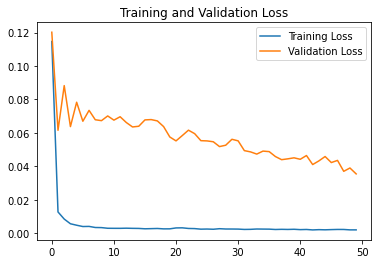

In [164]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

2022-10-01 21:14:22.939218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-01 21:14:23.019205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-01 21:14:23.124371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 51ms/step


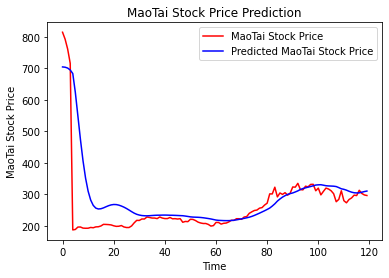

In [165]:
################## predict ######################

predicted_stock_price = model.predict(x_test)

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price = sc.inverse_transform(test_set[60:])

plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()


In [167]:
##########evaluate##############
# calculate MSE  
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('mse: %.6f' % mse)
print('rmse: %.6f' % rmse)
print('mae: %.6f' % mae)

mse: 6992.849618
rmse: 83.623260
mae: 38.833064
